In [2]:
!pip install scipy

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from scipy.signal.windows import gaussian
from scipy.ndimage import gaussian_filter

def praat_spectrogram(
    filepath,
    sr=None,
    window_length_sec=0.005,
    hop_length_sec=0.002,
    max_freq=5000,
    dynamic_range=55,
    preemph_cutoff=50,
    cmap='gray_r',
    interpolation='bilinear',
    dpi=200,
    show_colorbar=True,
    show_plot=True,
    save_path=None
):
    """
    Generate a Praat-like spectrogram with refined smoothing to preserve detail.

    Returns:
        S_db_smooth (np.ndarray): Smoothed spectrogram in dB.
        sr (int): Sample rate.
    """

    import librosa.display

    # Load audio
    y, sr = librosa.load(filepath, sr=sr)

    # Pre-emphasis filter
    pre_emph_coeff = np.exp(-2 * np.pi * preemph_cutoff / sr)
    y = np.append(y[0], y[1:] - pre_emph_coeff * y[:-1])

    # STFT setup
    win_length = int(window_length_sec * sr)
    hop_length = int(hop_length_sec * sr)
    n_fft = 2 ** int(np.ceil(np.log2(win_length)))
    window = gaussian(win_length, std=win_length / 6)

    # Compute STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

    # Dynamic range
    S_db[S_db < (np.max(S_db) - dynamic_range)] = np.max(S_db) - dynamic_range

    # --- Refined Smoothing (less aggressive) ---
    sigma_time = 1.0 / hop_length_sec  # preserves voicing detail
    sigma_freq = 1.2                   # tighter frequency smoothing

    S_db_smooth = gaussian_filter(S_db, sigma=[sigma_freq, sigma_time])

    # Display setup
    duration = len(y) / sr
    times = np.linspace(0, duration, S_db_smooth.shape[1])
    freqs = np.linspace(0, sr / 2, S_db_smooth.shape[0])

    if show_plot or save_path:
        fig, ax = plt.subplots(figsize=(10, 4), dpi=dpi)
        img = ax.imshow(S_db_smooth,
                        origin='lower',
                        aspect='auto',
                        interpolation=interpolation,
                        cmap=cmap,
                        extent=[times[0], times[-1], freqs[0], freqs[-1]])

        ax.set_title("Praat-like Spectrogram (Refined Detail)")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency (Hz)")
        ax.set_ylim(0, max_freq)

        if show_colorbar:
            fig.colorbar(img, ax=ax, label='dB')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        if show_plot:
            plt.show()
        else:
            plt.close()

    return S_db_smooth, sr


In [8]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

example = librosa.example('libri1')

In [9]:
example

'/root/.cache/librosa/5703-47212-0000.ogg'

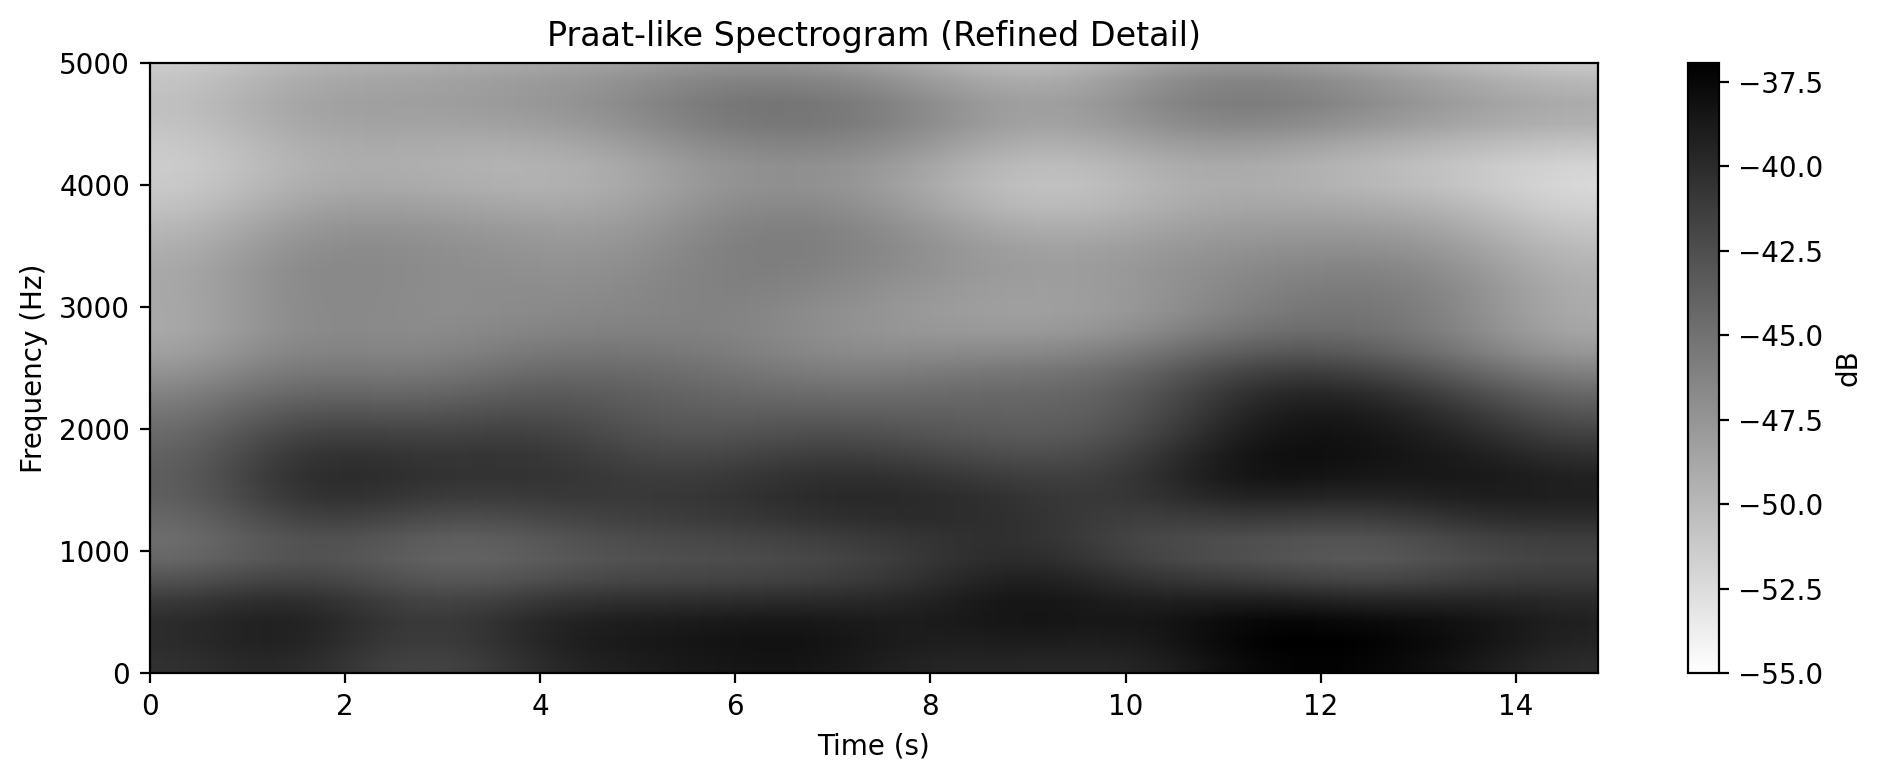

(array([[-40.42264094, -40.42263527, -40.42261625, ..., -40.01973418,
         -40.01975217, -40.01976162],
        [-40.07756822, -40.07756221, -40.07754298, ..., -39.49610659,
         -39.49612252, -39.49613119],
        [-40.10403086, -40.10402392, -40.10400528, ..., -39.27834391,
         -39.27835508, -39.27836121],
        ...,
        [-55.        , -55.        , -55.        , ..., -55.        ,
         -55.        , -55.        ],
        [-55.        , -55.        , -55.        , ..., -55.        ,
         -55.        , -55.        ],
        [-55.        , -55.        , -55.        , ..., -55.        ,
         -55.        , -55.        ]]),
 22050)

In [32]:
praat_spectrogram(example)